In [105]:
from pathlib import Path

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from scipy import stats

In [106]:
prompt_num = 3

In [107]:
root_dir = Path("/mnt/Enterprise/rabin/VL-Seg/")

In [108]:
lower_csv = root_dir / f"sdm_camus_metrics/cris/p{prompt_num}/metrics.csv"

In [109]:
higher_csv = root_dir / f"camus_metrics/cris/p{prompt_num}/metrics.csv"

In [198]:
def get_df(csv_path):
    df = pd.read_csv(csv_path, usecols=["filename", "dice", "iou"])
    df.filename = df.filename.apply(lambda x: "/".join(x.rsplit("/", 2)[1:]))
    return df.set_index("filename", verify_integrity=True).sort_index()

In [199]:
lower_df = get_df(lower_csv)

In [200]:
lower_df.head()

,iou,dice
filename,,
mask_1/patient0001_2CH_ED_gt.png,90.0687,94.7749
mask_1/patient0001_2CH_ES_gt.png,89.0929,94.2319
mask_1/patient0001_4CH_ED_gt.png,88.8992,94.1234
mask_1/patient0001_4CH_ES_gt.png,89.7335,94.5890
mask_1/patient0002_2CH_ED_gt.png,86.0461,92.4997


In [201]:
higher_df = get_df(higher_csv)

In [202]:
higher_df.head()

,iou,dice
filename,,
mask_1/patient0001_2CH_ED_gt.png,92.1889,95.9357
mask_1/patient0001_2CH_ES_gt.png,87.4412,93.2999
mask_1/patient0001_4CH_ED_gt.png,91.2298,95.4138
mask_1/patient0001_4CH_ES_gt.png,90.7312,95.1404
mask_1/patient0002_2CH_ED_gt.png,86.2830,92.6365


In [208]:
# Get the difference of each metric for each filename from higher_df and lower_df
diff_df = higher_df.copy()

for column in diff_df.columns:
    diff_df[column] -= lower_df[column].values

In [209]:
diff_df.head()

,iou,dice
filename,,
mask_1/patient0001_2CH_ED_gt.png,2.1202,1.1608
mask_1/patient0001_2CH_ES_gt.png,-1.6517,-0.9320
mask_1/patient0001_4CH_ED_gt.png,2.3306,1.2904
mask_1/patient0001_4CH_ES_gt.png,0.9977,0.5514
mask_1/patient0002_2CH_ED_gt.png,0.2369,0.1368


In [213]:
diff_df.mean(numeric_only=True)

iou     5.606525
dice    3.992619
dtype: float64

In [214]:
def plot_column(column, ax, n_samples=1000):
    column_data = diff_df[column]
    ax.hist(column_data, bins="auto", density=True, label="Hist")

    df, mu, sigma = stats.t.fit(column_data)

    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, n_samples)
    p = stats.t.pdf(x, df, mu, sigma)
    ax.plot(x, p, label="t-dist")

    ax.set_title(
        f"{column.title()} with $\mu={mu:.2f}$, $\sigma={sigma:.2f}$, $\\nu={df:.2f}$"
    )
    ax.legend()

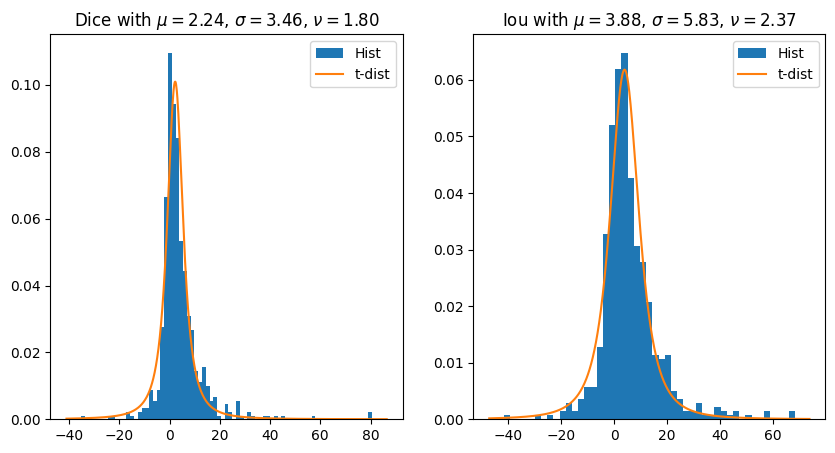

In [215]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

plot_column("dice", ax1)
plot_column("iou", ax2)

In [216]:
stats.ttest_rel(higher_df["dice"], lower_df["dice"], alternative="greater")

TtestResult(statistic=10.977576779105217, pvalue=5.673026308785891e-26, df=599)

In [222]:
stats.ttest_rel(higher_df["iou"], lower_df["iou"], alternative="greater")

TtestResult(statistic=12.682491049437354, pvalue=4.060844702979642e-33, df=599)